<a href="https://colab.research.google.com/github/sikbo/Git_tutorial/blob/main/yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

print(torch.version.cuda)

11.8


In [ ]:
!pip list

In [ ]:
!pip install -q super-gradients==3.2.0

In [ ]:
!pip install roboflow

In [ ]:
!pip install supervision

In [ ]:
import torch
from super_gradients.training import models

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_ARCH = 'yolo_nas_l'
#            'yolo_nas_m'
#            'yolo_nas_s'

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

[2023-08-22 14:31:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


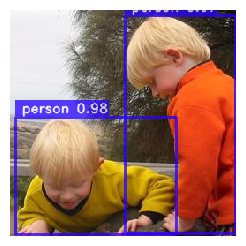

In [13]:
image = '/twins.tif'
CONFIDENCE_TRESHOLD = 0.35

result = list(model.predict(image, conf=CONFIDENCE_TRESHOLD))[0].show()


In [10]:
import roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EBwZmSUIkPfvLJEjyekH")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-2frwp")
dataset = project.version(1).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Football-Players-Detection-1 in yolov5pytorch:: 100%|██████████| 2258/2258 [00:00<00:00, 3940.80it/s]


In [11]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

In [12]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 5
MAX_EPOCHS = 15
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
LOCATION = dataset.location
CLASSES = ['ball', 'goalkeeper', 'player', 'referee']
WORKERS = 2

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'/content/Football-Players-Detection-1/train/images',
    'train_labels_dir':'/content/Football-Players-Detection-1/train/labels',
    'val_images_dir':'/content/Football-Players-Detection-1/valid/images',
    'val_labels_dir':'/content/Football-Players-Detection-1/valid/labels',
    'test_images_dir':'/content/Football-Players-Detection-1/test/images',
    'test_labels_dir':'/content/Football-Players-Detection-1/test/labels',
    'classes': CLASSES
}

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

[2023-08-22 16:36:26] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1072/1072 [00:00<00:00, 4448.97it/s]
[2023-08-22 16:36:27] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 38/38 [00:00<00:00, 3850.40it/s]


In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.transforms.pop(2)

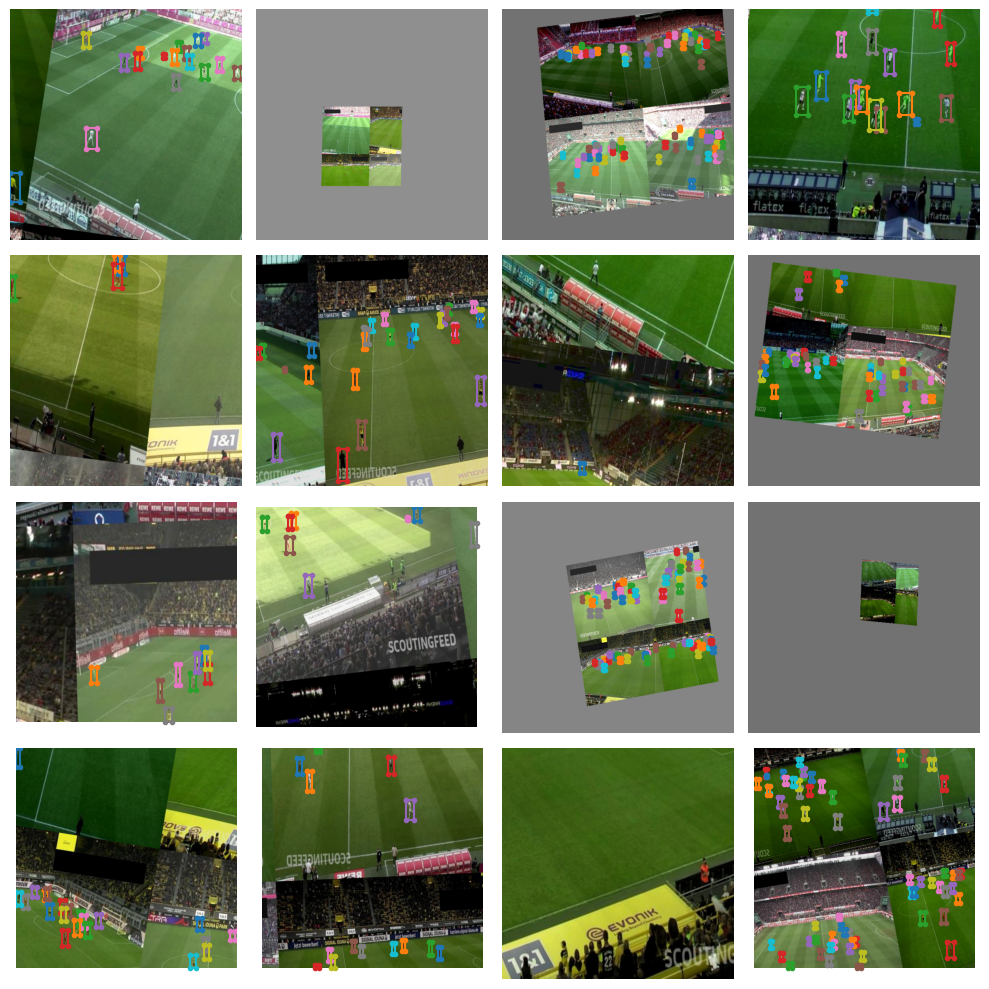

In [26]:
train_data.dataset.plot(plot_transformed_data=True)

In [13]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]

CHECKPOINT_DIR = 'checkpoints'

for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train,
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2023-08-22 16:36:43] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 201MB/s]
[2023-08-22 16:36:44] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


The console stream is now moved to checkpoints/yolo_nas_s/console_Aug22_16_36_44.txt


[2023-08-22 16:36:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-22 16:36:48] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1072       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         134        (len(train_loader))
    - Gradient updates per epoch:   134        (len(train_loader) / batch_accumulate)

[2023-08-22 16:36:48] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validating: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
[2023-08-22 16:38:31] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.3298
│   ├── Ppyoloeloss/loss_iou = 0.4008
│   ├── Ppyoloeloss/loss_dfl = 1.0334
│   └── Ppyoloeloss/loss = 3.8484
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5092
    ├── Ppyoloeloss/loss_iou = 0.2941
    ├── Ppyoloeloss/loss_dfl = 0.7416
    ├── Ppyoloeloss/loss = 3.6153
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0095
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0033
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
[2023-08-22 16:40:12] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:40:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.09497639536857605


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.954
│   │   ├── Epoch N-1      = 2.3298 (↘ -1.3757)
│   │   └── Best until now = 2.3298 (↘ -1.3757)
│   ├── Ppyoloeloss/loss_iou = 0.2762
│   │   ├── Epoch N-1      = 0.4008 (↘ -0.1246)
│   │   └── Best until now = 0.4008 (↘ -0.1246)
│   ├── Ppyoloeloss/loss_dfl = 0.7065
│   │   ├── Epoch N-1      = 1.0334 (↘ -0.3269)
│   │   └── Best until now = 1.0334 (↘ -0.3269)
│   └── Ppyoloeloss/loss = 1.9977
│       ├── Epoch N-1      = 3.8484 (↘ -1.8507)
│       └── Best until now = 3.8484 (↘ -1.8507)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.853
    │   ├── Epoch N-1      = 2.5092 (↘ -1.6563)
    │   └── Best until now = 2.5092 (↘ -1.6563)
    ├── Ppyoloeloss/loss_iou = 0.2568
    │   ├── Epoch N-1      = 0.2941 (↘ -0.0373)
    │   └── Best until now = 0.2941 (↘ -0.0373)
    ├── Ppyoloeloss/loss_dfl = 0.642
    │   ├── Epoch N-1      = 0.7416 (↘ -0.0995)
    │   └── Best until now = 0.7416 (↘ -0.0995)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
[2023-08-22 16:42:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:42:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.14563031494617462


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8476
│   │   ├── Epoch N-1      = 0.954  (↘ -0.1065)
│   │   └── Best until now = 0.954  (↘ -0.1065)
│   ├── Ppyoloeloss/loss_iou = 0.2478
│   │   ├── Epoch N-1      = 0.2762 (↘ -0.0284)
│   │   └── Best until now = 0.2762 (↘ -0.0284)
│   ├── Ppyoloeloss/loss_dfl = 0.6638
│   │   ├── Epoch N-1      = 0.7065 (↘ -0.0427)
│   │   └── Best until now = 0.7065 (↘ -0.0427)
│   └── Ppyoloeloss/loss = 1.7989
│       ├── Epoch N-1      = 1.9977 (↘ -0.1989)
│       └── Best until now = 1.9977 (↘ -0.1989)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8008
    │   ├── Epoch N-1      = 0.853  (↘ -0.0522)
    │   └── Best until now = 0.853  (↘ -0.0522)
    ├── Ppyoloeloss/loss_iou = 0.2239
    │   ├── Epoch N-1      = 0.2568 (↘ -0.0329)
    │   └── Best until now = 0.2568 (↘ -0.0329)
    ├── Ppyoloeloss/loss_dfl = 0.6074
    │   ├── Epoch N-1      = 0.642  (↘ -0.0347)
    │   └── Best until now = 0.642  (↘ -0.0347)
    ├── Ppyoloeloss/lo

Validating epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]
[2023-08-22 16:43:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:43:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24142499268054962


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8145
│   │   ├── Epoch N-1      = 0.8476 (↘ -0.033)
│   │   └── Best until now = 0.8476 (↘ -0.033)
│   ├── Ppyoloeloss/loss_iou = 0.2388
│   │   ├── Epoch N-1      = 0.2478 (↘ -0.009)
│   │   └── Best until now = 0.2478 (↘ -0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.6479
│   │   ├── Epoch N-1      = 0.6638 (↘ -0.016)
│   │   └── Best until now = 0.6638 (↘ -0.016)
│   └── Ppyoloeloss/loss = 1.7354
│       ├── Epoch N-1      = 1.7989 (↘ -0.0635)
│       └── Best until now = 1.7989 (↘ -0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7706
    │   ├── Epoch N-1      = 0.8008 (↘ -0.0302)
    │   └── Best until now = 0.8008 (↘ -0.0302)
    ├── Ppyoloeloss/loss_iou = 0.2225
    │   ├── Epoch N-1      = 0.2239 (↘ -0.0014)
    │   └── Best until now = 0.2239 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.599
    │   ├── Epoch N-1      = 0.6074 (↘ -0.0083)
    │   └── Best until now = 0.6074 (↘ -0.0083)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
[2023-08-22 16:45:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:45:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.30225393176078796


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7873
│   │   ├── Epoch N-1      = 0.8145 (↘ -0.0273)
│   │   └── Best until now = 0.8145 (↘ -0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.2307
│   │   ├── Epoch N-1      = 0.2388 (↘ -0.0081)
│   │   └── Best until now = 0.2388 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.6365
│   │   ├── Epoch N-1      = 0.6479 (↘ -0.0113)
│   │   └── Best until now = 0.6479 (↘ -0.0113)
│   └── Ppyoloeloss/loss = 1.6823
│       ├── Epoch N-1      = 1.7354 (↘ -0.0531)
│       └── Best until now = 1.7354 (↘ -0.0531)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.718
    │   ├── Epoch N-1      = 0.7706 (↘ -0.0526)
    │   └── Best until now = 0.7706 (↘ -0.0526)
    ├── Ppyoloeloss/loss_iou = 0.1932
    │   ├── Epoch N-1      = 0.2225 (↘ -0.0293)
    │   └── Best until now = 0.2225 (↘ -0.0293)
    ├── Ppyoloeloss/loss_dfl = 0.588
    │   ├── Epoch N-1      = 0.599  (↘ -0.011)
    │   └── Best until now = 0.599  (↘ -0.011)
    ├── Ppyoloeloss/loss =

Validating epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
[2023-08-22 16:47:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:47:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3312189280986786


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7711
│   │   ├── Epoch N-1      = 0.7873 (↘ -0.0161)
│   │   └── Best until now = 0.7873 (↘ -0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.2265
│   │   ├── Epoch N-1      = 0.2307 (↘ -0.0042)
│   │   └── Best until now = 0.2307 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6343
│   │   ├── Epoch N-1      = 0.6365 (↘ -0.0022)
│   │   └── Best until now = 0.6365 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.6547
│       ├── Epoch N-1      = 1.6823 (↘ -0.0276)
│       └── Best until now = 1.6823 (↘ -0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7108
    │   ├── Epoch N-1      = 0.718  (↘ -0.0071)
    │   └── Best until now = 0.718  (↘ -0.0071)
    ├── Ppyoloeloss/loss_iou = 0.1908
    │   ├── Epoch N-1      = 0.1932 (↘ -0.0023)
    │   └── Best until now = 0.1932 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.5849
    │   ├── Epoch N-1      = 0.588  (↘ -0.0031)
    │   └── Best until now = 0.588  (↘ -0.0031)
    ├── Ppyoloeloss/lo

Validating epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7537
│   │   ├── Epoch N-1      = 0.7711 (↘ -0.0175)
│   │   └── Best until now = 0.7711 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.2199
│   │   ├── Epoch N-1      = 0.2265 (↘ -0.0066)
│   │   └── Best until now = 0.2265 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6292
│   │   ├── Epoch N-1      = 0.6343 (↘ -0.0051)
│   │   └── Best until now = 0.6343 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 1.6181
│       ├── Epoch N-1      = 1.6547 (↘ -0.0365)
│       └── Best until now = 1.6547 (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.731
    │   ├── Epoch N-1      = 0.7108 (↗ 0.0202)
    │   └── Best until now = 0.7108 (↗ 0.0202)
    ├── Ppyoloeloss/loss_iou = 0.2045
    │   ├── Epoch N-1      = 0.1908 (↗ 0.0137)
    │   └── Best until now = 0.1908 (↗ 0.0137)
    ├── Ppyoloeloss/loss_dfl = 0.5885
    │   ├── Epoch N-1      = 0.5849 (↗ 0.0036)
    │   └── Best until now = 0.5849 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
[2023-08-22 16:51:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:51:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.33685940504074097


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7473
│   │   ├── Epoch N-1      = 0.7537 (↘ -0.0064)
│   │   └── Best until now = 0.7537 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.2179
│   │   ├── Epoch N-1      = 0.2199 (↘ -0.002)
│   │   └── Best until now = 0.2199 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.626
│   │   ├── Epoch N-1      = 0.6292 (↘ -0.0032)
│   │   └── Best until now = 0.6292 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.6051
│       ├── Epoch N-1      = 1.6181 (↘ -0.013)
│       └── Best until now = 1.6181 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7104
    │   ├── Epoch N-1      = 0.731  (↘ -0.0206)
    │   └── Best until now = 0.7108 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.1871
    │   ├── Epoch N-1      = 0.2045 (↘ -0.0174)
    │   └── Best until now = 0.1908 (↘ -0.0037)
    ├── Ppyoloeloss/loss_dfl = 0.582
    │   ├── Epoch N-1      = 0.5885 (↘ -0.0064)
    │   └── Best until now = 0.5849 (↘ -0.0029)
    ├── Ppyoloeloss/loss = 1

Validating epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7367
│   │   ├── Epoch N-1      = 0.7473 (↘ -0.0106)
│   │   └── Best until now = 0.7473 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.2144
│   │   ├── Epoch N-1      = 0.2179 (↘ -0.0035)
│   │   └── Best until now = 0.2179 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.6203
│   │   ├── Epoch N-1      = 0.626  (↘ -0.0057)
│   │   └── Best until now = 0.626  (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.5829
│       ├── Epoch N-1      = 1.6051 (↘ -0.0222)
│       └── Best until now = 1.6051 (↘ -0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7257
    │   ├── Epoch N-1      = 0.7104 (↗ 0.0152)
    │   └── Best until now = 0.7104 (↗ 0.0152)
    ├── Ppyoloeloss/loss_iou = 0.1899
    │   ├── Epoch N-1      = 0.1871 (↗ 0.0028)
    │   └── Best until now = 0.1871 (↗ 0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.5796
    │   ├── Epoch N-1      = 0.582  (↘ -0.0024)
    │   └── Best until now = 0.582  (↘ -0.0024)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7342
│   │   ├── Epoch N-1      = 0.7367 (↘ -0.0025)
│   │   └── Best until now = 0.7367 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.2144
│   │   ├── Epoch N-1      = 0.2144 (↘ -1e-04)
│   │   └── Best until now = 0.2144 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.6163
│   │   ├── Epoch N-1      = 0.6203 (↘ -0.004)
│   │   └── Best until now = 0.6203 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.5783
│       ├── Epoch N-1      = 1.5829 (↘ -0.0046)
│       └── Best until now = 1.5829 (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7279
    │   ├── Epoch N-1      = 0.7257 (↗ 0.0023)
    │   └── Best until now = 0.7104 (↗ 0.0175)
    ├── Ppyoloeloss/loss_iou = 0.2219
    │   ├── Epoch N-1      = 0.1899 (↗ 0.0319)
    │   └── Best until now = 0.1871 (↗ 0.0347)
    ├── Ppyoloeloss/loss_dfl = 0.5957
    │   ├── Epoch N-1      = 0.5796 (↗ 0.016)
    │   └── Best until now = 0.5796 (↗ 0.016)
    ├── Ppyoloeloss/loss = 1.5804


Validating epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
[2023-08-22 16:56:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 16:56:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3597278594970703


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7231
│   │   ├── Epoch N-1      = 0.7342 (↘ -0.0112)
│   │   └── Best until now = 0.7342 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.2091
│   │   ├── Epoch N-1      = 0.2144 (↘ -0.0053)
│   │   └── Best until now = 0.2144 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.6132
│   │   ├── Epoch N-1      = 0.6163 (↘ -0.0031)
│   │   └── Best until now = 0.6163 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.5524
│       ├── Epoch N-1      = 1.5783 (↘ -0.0259)
│       └── Best until now = 1.5783 (↘ -0.0259)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7044
    │   ├── Epoch N-1      = 0.7279 (↘ -0.0235)
    │   └── Best until now = 0.7104 (↘ -0.006)
    ├── Ppyoloeloss/loss_iou = 0.1947
    │   ├── Epoch N-1      = 0.2219 (↘ -0.0272)
    │   └── Best until now = 0.1871 (↗ 0.0075)
    ├── Ppyoloeloss/loss_dfl = 0.5799
    │   ├── Epoch N-1      = 0.5957 (↘ -0.0157)
    │   └── Best until now = 0.5796 (↗ 0.0003)
    ├── Ppyoloeloss/loss

Validating epoch 11: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.719
│   │   ├── Epoch N-1      = 0.7231 (↘ -0.004)
│   │   └── Best until now = 0.7231 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.2074
│   │   ├── Epoch N-1      = 0.2091 (↘ -0.0017)
│   │   └── Best until now = 0.2091 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.6116
│   │   ├── Epoch N-1      = 0.6132 (↘ -0.0016)
│   │   └── Best until now = 0.6132 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.5433
│       ├── Epoch N-1      = 1.5524 (↘ -0.0091)
│       └── Best until now = 1.5524 (↘ -0.0091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7022
    │   ├── Epoch N-1      = 0.7044 (↘ -0.0021)
    │   └── Best until now = 0.7044 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.1802
    │   ├── Epoch N-1      = 0.1947 (↘ -0.0145)
    │   └── Best until now = 0.1871 (↘ -0.007)
    ├── Ppyoloeloss/loss_dfl = 0.5778
    │   ├── Epoch N-1      = 0.5799 (↘ -0.0021)
    │   └── Best until now = 0.5796 (↘ -0.0018)
    ├── Ppyoloeloss/loss 

Validating epoch 12: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.714
│   │   ├── Epoch N-1      = 0.719  (↘ -0.005)
│   │   └── Best until now = 0.719  (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.2056
│   │   ├── Epoch N-1      = 0.2074 (↘ -0.0018)
│   │   └── Best until now = 0.2074 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6093
│   │   ├── Epoch N-1      = 0.6116 (↘ -0.0023)
│   │   └── Best until now = 0.6116 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.5327
│       ├── Epoch N-1      = 1.5433 (↘ -0.0107)
│       └── Best until now = 1.5433 (↘ -0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7365
    │   ├── Epoch N-1      = 0.7022 (↗ 0.0342)
    │   └── Best until now = 0.7022 (↗ 0.0342)
    ├── Ppyoloeloss/loss_iou = 0.2187
    │   ├── Epoch N-1      = 0.1802 (↗ 0.0386)
    │   └── Best until now = 0.1802 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.5855
    │   ├── Epoch N-1      = 0.5778 (↗ 0.0077)
    │   └── Best until now = 0.5778 (↗ 0.0077)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7067
│   │   ├── Epoch N-1      = 0.714  (↘ -0.0073)
│   │   └── Best until now = 0.714  (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.2033
│   │   ├── Epoch N-1      = 0.2056 (↘ -0.0024)
│   │   └── Best until now = 0.2056 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6098
│   │   ├── Epoch N-1      = 0.6093 (↗ 0.0005)
│   │   └── Best until now = 0.6093 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 1.5197
│       ├── Epoch N-1      = 1.5327 (↘ -0.0129)
│       └── Best until now = 1.5327 (↘ -0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6829
    │   ├── Epoch N-1      = 0.7365 (↘ -0.0536)
    │   └── Best until now = 0.7022 (↘ -0.0194)
    ├── Ppyoloeloss/loss_iou = 0.1886
    │   ├── Epoch N-1      = 0.2187 (↘ -0.0301)
    │   └── Best until now = 0.1802 (↗ 0.0084)
    ├── Ppyoloeloss/loss_dfl = 0.5801
    │   ├── Epoch N-1      = 0.5855 (↘ -0.0054)
    │   └── Best until now = 0.5778 (↗ 0.0023)
    ├── Ppyoloeloss/loss 

Validating epoch 14: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6961
│   │   ├── Epoch N-1      = 0.7067 (↘ -0.0106)
│   │   └── Best until now = 0.7067 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.2006
│   │   ├── Epoch N-1      = 0.2033 (↘ -0.0026)
│   │   └── Best until now = 0.2033 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.6029
│   │   ├── Epoch N-1      = 0.6098 (↘ -0.007)
│   │   └── Best until now = 0.6093 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.4992
│       ├── Epoch N-1      = 1.5197 (↘ -0.0206)
│       └── Best until now = 1.5197 (↘ -0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6872
    │   ├── Epoch N-1      = 0.6829 (↗ 0.0044)
    │   └── Best until now = 0.6829 (↗ 0.0044)
    ├── Ppyoloeloss/loss_iou = 0.2013
    │   ├── Epoch N-1      = 0.1886 (↗ 0.0127)
    │   └── Best until now = 0.1802 (↗ 0.0211)
    ├── Ppyoloeloss/loss_dfl = 0.5838
    │   ├── Epoch N-1      = 0.5801 (↗ 0.0037)
    │   └── Best until now = 0.5778 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 15: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6958
│   │   ├── Epoch N-1      = 0.6961 (↘ -0.0003)
│   │   └── Best until now = 0.6961 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.1998
│   │   ├── Epoch N-1      = 0.2006 (↘ -0.0008)
│   │   └── Best until now = 0.2006 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.6023
│   │   ├── Epoch N-1      = 0.6029 (↘ -0.0006)
│   │   └── Best until now = 0.6029 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.4965
│       ├── Epoch N-1      = 1.4992 (↘ -0.0027)
│       └── Best until now = 1.4992 (↘ -0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7091
    │   ├── Epoch N-1      = 0.6872 (↗ 0.0218)
    │   └── Best until now = 0.6829 (↗ 0.0262)
    ├── Ppyoloeloss/loss_iou = 0.2055
    │   ├── Epoch N-1      = 0.2013 (↗ 0.0042)
    │   └── Best until now = 0.1802 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.5821
    │   ├── Epoch N-1      = 0.5838 (↘ -0.0017)
    │   └── Best until now = 0.5778 (↗ 0.0043)
    ├── Ppyoloeloss/loss =

Validating epoch 16: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]
[2023-08-22 17:07:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 17:07:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3683641850948334


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6916
│   │   ├── Epoch N-1      = 0.6958 (↘ -0.0043)
│   │   └── Best until now = 0.6958 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.1978
│   │   ├── Epoch N-1      = 0.1998 (↘ -0.002)
│   │   └── Best until now = 0.1998 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6017
│   │   ├── Epoch N-1      = 0.6023 (↘ -0.0006)
│   │   └── Best until now = 0.6023 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.4869
│       ├── Epoch N-1      = 1.4965 (↘ -0.0096)
│       └── Best until now = 1.4965 (↘ -0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6923
    │   ├── Epoch N-1      = 0.7091 (↘ -0.0168)
    │   └── Best until now = 0.6829 (↗ 0.0094)
    ├── Ppyoloeloss/loss_iou = 0.1906
    │   ├── Epoch N-1      = 0.2055 (↘ -0.0149)
    │   └── Best until now = 0.1802 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.5757
    │   ├── Epoch N-1      = 0.5821 (↘ -0.0065)
    │   └── Best until now = 0.5778 (↘ -0.0021)
    ├── Ppyoloeloss/loss 

Validating epoch 17: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6836
│   │   ├── Epoch N-1      = 0.6916 (↘ -0.008)
│   │   └── Best until now = 0.6916 (↘ -0.008)
│   ├── Ppyoloeloss/loss_iou = 0.1954
│   │   ├── Epoch N-1      = 0.1978 (↘ -0.0024)
│   │   └── Best until now = 0.1978 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.5993
│   │   ├── Epoch N-1      = 0.6017 (↘ -0.0023)
│   │   └── Best until now = 0.6017 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.4718
│       ├── Epoch N-1      = 1.4869 (↘ -0.0151)
│       └── Best until now = 1.4869 (↘ -0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7507
    │   ├── Epoch N-1      = 0.6923 (↗ 0.0584)
    │   └── Best until now = 0.6829 (↗ 0.0679)
    ├── Ppyoloeloss/loss_iou = 0.2437
    │   ├── Epoch N-1      = 0.1906 (↗ 0.0532)
    │   └── Best until now = 0.1802 (↗ 0.0636)
    ├── Ppyoloeloss/loss_dfl = 0.5926
    │   ├── Epoch N-1      = 0.5757 (↗ 0.017)
    │   └── Best until now = 0.5757 (↗ 0.017)
    ├── Ppyoloeloss/loss = 1.65

Validating epoch 18: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]
[2023-08-22 17:11:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 17:11:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3684427738189697


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6794
│   │   ├── Epoch N-1      = 0.6836 (↘ -0.0043)
│   │   └── Best until now = 0.6836 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.1932
│   │   ├── Epoch N-1      = 0.1954 (↘ -0.0021)
│   │   └── Best until now = 0.1954 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.5996
│   │   ├── Epoch N-1      = 0.5993 (↗ 0.0003)
│   │   └── Best until now = 0.5993 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.4623
│       ├── Epoch N-1      = 1.4718 (↘ -0.0095)
│       └── Best until now = 1.4718 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6821
    │   ├── Epoch N-1      = 0.7507 (↘ -0.0687)
    │   └── Best until now = 0.6829 (↘ -0.0008)
    ├── Ppyoloeloss/loss_iou = 0.2022
    │   ├── Epoch N-1      = 0.2437 (↘ -0.0415)
    │   └── Best until now = 0.1802 (↗ 0.0221)
    ├── Ppyoloeloss/loss_dfl = 0.5805
    │   ├── Epoch N-1      = 0.5926 (↘ -0.0122)
    │   └── Best until now = 0.5757 (↗ 0.0048)
    ├── Ppyoloeloss/loss 

Validating epoch 19: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6756
│   │   ├── Epoch N-1      = 0.6794 (↘ -0.0037)
│   │   └── Best until now = 0.6794 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.1918
│   │   ├── Epoch N-1      = 0.1932 (↘ -0.0015)
│   │   └── Best until now = 0.1932 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5968
│   │   ├── Epoch N-1      = 0.5996 (↘ -0.0028)
│   │   └── Best until now = 0.5993 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.4534
│       ├── Epoch N-1      = 1.4623 (↘ -0.0089)
│       └── Best until now = 1.4623 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7057
    │   ├── Epoch N-1      = 0.6821 (↗ 0.0237)
    │   └── Best until now = 0.6821 (↗ 0.0237)
    ├── Ppyoloeloss/loss_iou = 0.2076
    │   ├── Epoch N-1      = 0.2022 (↗ 0.0054)
    │   └── Best until now = 0.1802 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.5843
    │   ├── Epoch N-1      = 0.5805 (↗ 0.0038)
    │   └── Best until now = 0.5757 (↗ 0.0086)
    ├── Ppyoloeloss/loss = 

Validating epoch 20: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]
[2023-08-22 17:14:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 17:14:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3758077323436737


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6721
│   │   ├── Epoch N-1      = 0.6756 (↘ -0.0035)
│   │   └── Best until now = 0.6756 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.1922
│   │   ├── Epoch N-1      = 0.1918 (↗ 0.0005)
│   │   └── Best until now = 0.1918 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5941
│   │   ├── Epoch N-1      = 0.5968 (↘ -0.0027)
│   │   └── Best until now = 0.5968 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.4497
│       ├── Epoch N-1      = 1.4534 (↘ -0.0037)
│       └── Best until now = 1.4534 (↘ -0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6906
    │   ├── Epoch N-1      = 0.7057 (↘ -0.0151)
    │   └── Best until now = 0.6821 (↗ 0.0086)
    ├── Ppyoloeloss/loss_iou = 0.2092
    │   ├── Epoch N-1      = 0.2076 (↗ 0.0016)
    │   └── Best until now = 0.1802 (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 0.5831
    │   ├── Epoch N-1      = 0.5843 (↘ -0.0012)
    │   └── Best until now = 0.5757 (↗ 0.0075)
    ├── Ppyoloeloss/loss = 

Validating epoch 21: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6651
│   │   ├── Epoch N-1      = 0.6721 (↘ -0.007)
│   │   └── Best until now = 0.6721 (↘ -0.007)
│   ├── Ppyoloeloss/loss_iou = 0.1896
│   │   ├── Epoch N-1      = 0.1922 (↘ -0.0026)
│   │   └── Best until now = 0.1918 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.592
│   │   ├── Epoch N-1      = 0.5941 (↘ -0.0021)
│   │   └── Best until now = 0.5941 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.4351
│       ├── Epoch N-1      = 1.4497 (↘ -0.0146)
│       └── Best until now = 1.4497 (↘ -0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7153
    │   ├── Epoch N-1      = 0.6906 (↗ 0.0247)
    │   └── Best until now = 0.6821 (↗ 0.0333)
    ├── Ppyoloeloss/loss_iou = 0.2191
    │   ├── Epoch N-1      = 0.2092 (↗ 0.0099)
    │   └── Best until now = 0.1802 (↗ 0.0389)
    ├── Ppyoloeloss/loss_dfl = 0.584
    │   ├── Epoch N-1      = 0.5831 (↗ 0.0009)
    │   └── Best until now = 0.5757 (↗ 0.0083)
    ├── Ppyoloeloss/loss = 1.55

Validating epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
[2023-08-22 17:18:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 17:18:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.38066840171813965


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6604
│   │   ├── Epoch N-1      = 0.6651 (↘ -0.0047)
│   │   └── Best until now = 0.6651 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.1868
│   │   ├── Epoch N-1      = 0.1896 (↘ -0.0028)
│   │   └── Best until now = 0.1896 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.592
│   │   ├── Epoch N-1      = 0.592  (↗ 1e-04)
│   │   └── Best until now = 0.592  (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.4235
│       ├── Epoch N-1      = 1.4351 (↘ -0.0117)
│       └── Best until now = 1.4351 (↘ -0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6685
    │   ├── Epoch N-1      = 0.7153 (↘ -0.0468)
    │   └── Best until now = 0.6821 (↘ -0.0136)
    ├── Ppyoloeloss/loss_iou = 0.1912
    │   ├── Epoch N-1      = 0.2191 (↘ -0.0279)
    │   └── Best until now = 0.1802 (↗ 0.0111)
    ├── Ppyoloeloss/loss_dfl = 0.5732
    │   ├── Epoch N-1      = 0.584  (↘ -0.0108)
    │   └── Best until now = 0.5757 (↘ -0.0024)
    ├── Ppyoloeloss/loss = 

Validating epoch 23: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
[2023-08-22 17:20:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-08-22 17:20:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3987289071083069


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6615
│   │   ├── Epoch N-1      = 0.6604 (↗ 0.0011)
│   │   └── Best until now = 0.6604 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.1878
│   │   ├── Epoch N-1      = 0.1868 (↗ 0.001)
│   │   └── Best until now = 0.1868 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5927
│   │   ├── Epoch N-1      = 0.592  (↗ 0.0006)
│   │   └── Best until now = 0.592  (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.4274
│       ├── Epoch N-1      = 1.4235 (↗ 0.0039)
│       └── Best until now = 1.4235 (↗ 0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6573
    │   ├── Epoch N-1      = 0.6685 (↘ -0.0112)
    │   └── Best until now = 0.6685 (↘ -0.0112)
    ├── Ppyoloeloss/loss_iou = 0.186
    │   ├── Epoch N-1      = 0.1912 (↘ -0.0052)
    │   └── Best until now = 0.1802 (↗ 0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.5716
    │   ├── Epoch N-1      = 0.5732 (↘ -0.0016)
    │   └── Best until now = 0.5732 (↘ -0.0016)
    ├── Ppyoloeloss/loss = 1.408


Validating epoch 24: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6586
│   │   ├── Epoch N-1      = 0.6615 (↘ -0.003)
│   │   └── Best until now = 0.6604 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.1861
│   │   ├── Epoch N-1      = 0.1878 (↘ -0.0017)
│   │   └── Best until now = 0.1868 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.5901
│   │   ├── Epoch N-1      = 0.5927 (↘ -0.0025)
│   │   └── Best until now = 0.592  (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.4188
│       ├── Epoch N-1      = 1.4274 (↘ -0.0086)
│       └── Best until now = 1.4235 (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6845
    │   ├── Epoch N-1      = 0.6573 (↗ 0.0273)
    │   └── Best until now = 0.6573 (↗ 0.0273)
    ├── Ppyoloeloss/loss_iou = 0.2077
    │   ├── Epoch N-1      = 0.186  (↗ 0.0217)
    │   └── Best until now = 0.1802 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.5807
    │   ├── Epoch N-1      = 0.5716 (↗ 0.0092)
    │   └── Best until now = 0.5716 (↗ 0.0092)
    ├── Ppyoloeloss/loss = 1

[2023-08-22 17:22:59] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
[2023-08-22 17:23:03] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-08-22 17:23:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:00<00:00, 278MB/s]
[2023-08-22 17:23:06] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


The console stream is now moved to checkpoints/yolo_nas_m/console_Aug22_17_23_06.txt


[2023-08-22 17:23:07] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-22 17:23:09] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1072       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         134        (len(train_loader))
    - Gradient updates per epoch:   134        (len(train_loader) / batch_accumulate)

[2023-08-22 17:23:09] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
[2023-08-22 17:25:05] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.0761
│   ├── Ppyoloeloss/loss_iou = 0.3417
│   ├── Ppyoloeloss/loss_dfl = 0.9198
│   └── Ppyoloeloss/loss = 3.3902
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8897
    ├── Ppyoloeloss/loss_iou = 0.2557
    ├── Ppyoloeloss/loss_dfl = 0.6751
    ├── Ppyoloeloss/loss = 2.8665
    ├── Precision@0.50 = 0.2333
    ├── Recall@0.50 = 0.008
    ├── Map@0.50 = 0.1043
    ├── F1@0.50 = 0.0154
    ├── Precision@0.50:0.95 = 0.1205
    ├── Recall@0.50:0.95 = 0.0039
    ├── Map@0.50:0.95 = 0.044
    └── F1@0.50:0.95 = 0.0075



Validating epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
[2023-08-22 17:27:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:27:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1429622322320938


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8956
│   │   ├── Epoch N-1      = 2.0761 (↘ -1.1805)
│   │   └── Best until now = 2.0761 (↘ -1.1805)
│   ├── Ppyoloeloss/loss_iou = 0.2522
│   │   ├── Epoch N-1      = 0.3417 (↘ -0.0895)
│   │   └── Best until now = 0.3417 (↘ -0.0895)
│   ├── Ppyoloeloss/loss_dfl = 0.679
│   │   ├── Epoch N-1      = 0.9198 (↘ -0.2408)
│   │   └── Best until now = 0.9198 (↘ -0.2408)
│   └── Ppyoloeloss/loss = 1.8655
│       ├── Epoch N-1      = 3.3902 (↘ -1.5247)
│       └── Best until now = 3.3902 (↘ -1.5247)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8009
    │   ├── Epoch N-1      = 1.8897 (↘ -1.0888)
    │   └── Best until now = 1.8897 (↘ -1.0888)
    ├── Ppyoloeloss/loss_iou = 0.2182
    │   ├── Epoch N-1      = 0.2557 (↘ -0.0375)
    │   └── Best until now = 0.2557 (↘ -0.0375)
    ├── Ppyoloeloss/loss_dfl = 0.6069
    │   ├── Epoch N-1      = 0.6751 (↘ -0.0682)
    │   └── Best until now = 0.6751 (↘ -0.0682)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
[2023-08-22 17:29:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:29:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23259253799915314


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8165
│   │   ├── Epoch N-1      = 0.8956 (↘ -0.0791)
│   │   └── Best until now = 0.8956 (↘ -0.0791)
│   ├── Ppyoloeloss/loss_iou = 0.232
│   │   ├── Epoch N-1      = 0.2522 (↘ -0.0202)
│   │   └── Best until now = 0.2522 (↘ -0.0202)
│   ├── Ppyoloeloss/loss_dfl = 0.6472
│   │   ├── Epoch N-1      = 0.679  (↘ -0.0318)
│   │   └── Best until now = 0.679  (↘ -0.0318)
│   └── Ppyoloeloss/loss = 1.7201
│       ├── Epoch N-1      = 1.8655 (↘ -0.1454)
│       └── Best until now = 1.8655 (↘ -0.1454)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7422
    │   ├── Epoch N-1      = 0.8009 (↘ -0.0587)
    │   └── Best until now = 0.8009 (↘ -0.0587)
    ├── Ppyoloeloss/loss_iou = 0.1948
    │   ├── Epoch N-1      = 0.2182 (↘ -0.0234)
    │   └── Best until now = 0.2182 (↘ -0.0234)
    ├── Ppyoloeloss/loss_dfl = 0.5915
    │   ├── Epoch N-1      = 0.6069 (↘ -0.0154)
    │   └── Best until now = 0.6069 (↘ -0.0154)
    ├── Ppyoloeloss/los

Validating epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
[2023-08-22 17:31:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:31:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3086036145687103


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7798
│   │   ├── Epoch N-1      = 0.8165 (↘ -0.0367)
│   │   └── Best until now = 0.8165 (↘ -0.0367)
│   ├── Ppyoloeloss/loss_iou = 0.2275
│   │   ├── Epoch N-1      = 0.232  (↘ -0.0045)
│   │   └── Best until now = 0.232  (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6385
│   │   ├── Epoch N-1      = 0.6472 (↘ -0.0087)
│   │   └── Best until now = 0.6472 (↘ -0.0087)
│   └── Ppyoloeloss/loss = 1.6678
│       ├── Epoch N-1      = 1.7201 (↘ -0.0523)
│       └── Best until now = 1.7201 (↘ -0.0523)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7219
    │   ├── Epoch N-1      = 0.7422 (↘ -0.0203)
    │   └── Best until now = 0.7422 (↘ -0.0203)
    ├── Ppyoloeloss/loss_iou = 0.2152
    │   ├── Epoch N-1      = 0.1948 (↗ 0.0204)
    │   └── Best until now = 0.1948 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.5925
    │   ├── Epoch N-1      = 0.5915 (↗ 0.001)
    │   └── Best until now = 0.5915 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1

Validating epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
[2023-08-22 17:33:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:33:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.35510894656181335


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7523
│   │   ├── Epoch N-1      = 0.7798 (↘ -0.0276)
│   │   └── Best until now = 0.7798 (↘ -0.0276)
│   ├── Ppyoloeloss/loss_iou = 0.2209
│   │   ├── Epoch N-1      = 0.2275 (↘ -0.0066)
│   │   └── Best until now = 0.2275 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6266
│   │   ├── Epoch N-1      = 0.6385 (↘ -0.0119)
│   │   └── Best until now = 0.6385 (↘ -0.0119)
│   └── Ppyoloeloss/loss = 1.6179
│       ├── Epoch N-1      = 1.6678 (↘ -0.0499)
│       └── Best until now = 1.6678 (↘ -0.0499)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6794
    │   ├── Epoch N-1      = 0.7219 (↘ -0.0426)
    │   └── Best until now = 0.7219 (↘ -0.0426)
    ├── Ppyoloeloss/loss_iou = 0.1855
    │   ├── Epoch N-1      = 0.2152 (↘ -0.0297)
    │   └── Best until now = 0.1948 (↘ -0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.5821
    │   ├── Epoch N-1      = 0.5925 (↘ -0.0104)
    │   └── Best until now = 0.5915 (↘ -0.0094)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]
[2023-08-22 17:35:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:35:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36586952209472656


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7401
│   │   ├── Epoch N-1      = 0.7523 (↘ -0.0121)
│   │   └── Best until now = 0.7523 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.2166
│   │   ├── Epoch N-1      = 0.2209 (↘ -0.0044)
│   │   └── Best until now = 0.2209 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.6243
│   │   ├── Epoch N-1      = 0.6266 (↘ -0.0023)
│   │   └── Best until now = 0.6266 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.5937
│       ├── Epoch N-1      = 1.6179 (↘ -0.0242)
│       └── Best until now = 1.6179 (↘ -0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6968
    │   ├── Epoch N-1      = 0.6794 (↗ 0.0175)
    │   └── Best until now = 0.6794 (↗ 0.0175)
    ├── Ppyoloeloss/loss_iou = 0.1802
    │   ├── Epoch N-1      = 0.1855 (↘ -0.0053)
    │   └── Best until now = 0.1855 (↘ -0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.5779
    │   ├── Epoch N-1      = 0.5821 (↘ -0.0042)
    │   └── Best until now = 0.5821 (↘ -0.0042)
    ├── Ppyoloeloss/loss

Validating epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7256
│   │   ├── Epoch N-1      = 0.7401 (↘ -0.0145)
│   │   └── Best until now = 0.7401 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.2096
│   │   ├── Epoch N-1      = 0.2166 (↘ -0.0069)
│   │   └── Best until now = 0.2166 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.619
│   │   ├── Epoch N-1      = 0.6243 (↘ -0.0053)
│   │   └── Best until now = 0.6243 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 1.5592
│       ├── Epoch N-1      = 1.5937 (↘ -0.0345)
│       └── Best until now = 1.5937 (↘ -0.0345)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7248
    │   ├── Epoch N-1      = 0.6968 (↗ 0.028)
    │   └── Best until now = 0.6794 (↗ 0.0455)
    ├── Ppyoloeloss/loss_iou = 0.2182
    │   ├── Epoch N-1      = 0.1802 (↗ 0.038)
    │   └── Best until now = 0.1802 (↗ 0.038)
    ├── Ppyoloeloss/loss_dfl = 0.5857
    │   ├── Epoch N-1      = 0.5779 (↗ 0.0078)
    │   └── Best until now = 0.5779 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 1.563

Validating epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
[2023-08-22 17:40:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 17:40:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.38230305910110474


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7178
│   │   ├── Epoch N-1      = 0.7256 (↘ -0.0078)
│   │   └── Best until now = 0.7256 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.2072
│   │   ├── Epoch N-1      = 0.2096 (↘ -0.0024)
│   │   └── Best until now = 0.2096 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6158
│   │   ├── Epoch N-1      = 0.619  (↘ -0.0032)
│   │   └── Best until now = 0.619  (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.5437
│       ├── Epoch N-1      = 1.5592 (↘ -0.0155)
│       └── Best until now = 1.5592 (↘ -0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6688
    │   ├── Epoch N-1      = 0.7248 (↘ -0.0561)
    │   └── Best until now = 0.6794 (↘ -0.0106)
    ├── Ppyoloeloss/loss_iou = 0.1861
    │   ├── Epoch N-1      = 0.2182 (↘ -0.0322)
    │   └── Best until now = 0.1802 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.576
    │   ├── Epoch N-1      = 0.5857 (↘ -0.0097)
    │   └── Best until now = 0.5779 (↘ -0.002)
    ├── Ppyoloeloss/loss 

Validating epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7084
│   │   ├── Epoch N-1      = 0.7178 (↘ -0.0095)
│   │   └── Best until now = 0.7178 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.2044
│   │   ├── Epoch N-1      = 0.2072 (↘ -0.0028)
│   │   └── Best until now = 0.2072 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6106
│   │   ├── Epoch N-1      = 0.6158 (↘ -0.0052)
│   │   └── Best until now = 0.6158 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.5246
│       ├── Epoch N-1      = 1.5437 (↘ -0.0192)
│       └── Best until now = 1.5437 (↘ -0.0192)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6956
    │   ├── Epoch N-1      = 0.6688 (↗ 0.0268)
    │   └── Best until now = 0.6688 (↗ 0.0268)
    ├── Ppyoloeloss/loss_iou = 0.1869
    │   ├── Epoch N-1      = 0.1861 (↗ 0.0008)
    │   └── Best until now = 0.1802 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.5764
    │   ├── Epoch N-1      = 0.576  (↗ 0.0004)
    │   └── Best until now = 0.576  (↗ 0.0004)
    ├── Ppyoloeloss/loss = 1

Validating epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7076
│   │   ├── Epoch N-1      = 0.7084 (↘ -0.0008)
│   │   └── Best until now = 0.7084 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.2037
│   │   ├── Epoch N-1      = 0.2044 (↘ -0.0006)
│   │   └── Best until now = 0.2044 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.6062
│   │   ├── Epoch N-1      = 0.6106 (↘ -0.0044)
│   │   └── Best until now = 0.6106 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.52
│       ├── Epoch N-1      = 1.5246 (↘ -0.0046)
│       └── Best until now = 1.5246 (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7522
    │   ├── Epoch N-1      = 0.6956 (↗ 0.0566)
    │   └── Best until now = 0.6688 (↗ 0.0834)
    ├── Ppyoloeloss/loss_iou = 0.2253
    │   ├── Epoch N-1      = 0.1869 (↗ 0.0384)
    │   └── Best until now = 0.1802 (↗ 0.0451)
    ├── Ppyoloeloss/loss_dfl = 0.5932
    │   ├── Epoch N-1      = 0.5764 (↗ 0.0169)
    │   └── Best until now = 0.576  (↗ 0.0173)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6965
│   │   ├── Epoch N-1      = 0.7076 (↘ -0.0111)
│   │   └── Best until now = 0.7076 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.1992
│   │   ├── Epoch N-1      = 0.2037 (↘ -0.0045)
│   │   └── Best until now = 0.2037 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6048
│   │   ├── Epoch N-1      = 0.6062 (↘ -0.0014)
│   │   └── Best until now = 0.6062 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.4969
│       ├── Epoch N-1      = 1.52   (↘ -0.0231)
│       └── Best until now = 1.52   (↘ -0.0231)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6841
    │   ├── Epoch N-1      = 0.7522 (↘ -0.068)
    │   └── Best until now = 0.6688 (↗ 0.0154)
    ├── Ppyoloeloss/loss_iou = 0.196
    │   ├── Epoch N-1      = 0.2253 (↘ -0.0294)
    │   └── Best until now = 0.1802 (↗ 0.0158)
    ├── Ppyoloeloss/loss_dfl = 0.5783
    │   ├── Epoch N-1      = 0.5932 (↘ -0.015)
    │   └── Best until now = 0.576  (↗ 0.0023)
    ├── Ppyoloeloss/loss = 

Validating epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6922
│   │   ├── Epoch N-1      = 0.6965 (↘ -0.0043)
│   │   └── Best until now = 0.6965 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.1974
│   │   ├── Epoch N-1      = 0.1992 (↘ -0.0018)
│   │   └── Best until now = 0.1992 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6029
│   │   ├── Epoch N-1      = 0.6048 (↘ -0.0019)
│   │   └── Best until now = 0.6048 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.4871
│       ├── Epoch N-1      = 1.4969 (↘ -0.0098)
│       └── Best until now = 1.4969 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6901
    │   ├── Epoch N-1      = 0.6841 (↗ 0.006)
    │   └── Best until now = 0.6688 (↗ 0.0214)
    ├── Ppyoloeloss/loss_iou = 0.1946
    │   ├── Epoch N-1      = 0.196  (↘ -0.0013)
    │   └── Best until now = 0.1802 (↗ 0.0144)
    ├── Ppyoloeloss/loss_dfl = 0.5807
    │   ├── Epoch N-1      = 0.5783 (↗ 0.0024)
    │   └── Best until now = 0.576  (↗ 0.0047)
    ├── Ppyoloeloss/loss = 

Validating epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6873
│   │   ├── Epoch N-1      = 0.6922 (↘ -0.0048)
│   │   └── Best until now = 0.6922 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.1963
│   │   ├── Epoch N-1      = 0.1974 (↘ -0.0011)
│   │   └── Best until now = 0.1974 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.601
│   │   ├── Epoch N-1      = 0.6029 (↘ -0.0018)
│   │   └── Best until now = 0.6029 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.4786
│       ├── Epoch N-1      = 1.4871 (↘ -0.0085)
│       └── Best until now = 1.4871 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.699
    │   ├── Epoch N-1      = 0.6901 (↗ 0.0089)
    │   └── Best until now = 0.6688 (↗ 0.0302)
    ├── Ppyoloeloss/loss_iou = 0.2075
    │   ├── Epoch N-1      = 0.1946 (↗ 0.0129)
    │   └── Best until now = 0.1802 (↗ 0.0273)
    ├── Ppyoloeloss/loss_dfl = 0.577
    │   ├── Epoch N-1      = 0.5807 (↘ -0.0036)
    │   └── Best until now = 0.576  (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6786
│   │   ├── Epoch N-1      = 0.6873 (↘ -0.0087)
│   │   └── Best until now = 0.6873 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.1935
│   │   ├── Epoch N-1      = 0.1963 (↘ -0.0028)
│   │   └── Best until now = 0.1963 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6019
│   │   ├── Epoch N-1      = 0.601  (↗ 0.0009)
│   │   └── Best until now = 0.601  (↗ 0.0009)
│   └── Ppyoloeloss/loss = 1.4632
│       ├── Epoch N-1      = 1.4786 (↘ -0.0154)
│       └── Best until now = 1.4786 (↘ -0.0154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.651
    │   ├── Epoch N-1      = 0.699  (↘ -0.048)
    │   └── Best until now = 0.6688 (↘ -0.0177)
    ├── Ppyoloeloss/loss_iou = 0.1862
    │   ├── Epoch N-1      = 0.2075 (↘ -0.0214)
    │   └── Best until now = 0.1802 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 0.5745
    │   ├── Epoch N-1      = 0.577  (↘ -0.0026)
    │   └── Best until now = 0.576  (↘ -0.0015)
    ├── Ppyoloeloss/loss = 

Validating epoch 14: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.669
│   │   ├── Epoch N-1      = 0.6786 (↘ -0.0096)
│   │   └── Best until now = 0.6786 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.1901
│   │   ├── Epoch N-1      = 0.1935 (↘ -0.0034)
│   │   └── Best until now = 0.1935 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.5943
│   │   ├── Epoch N-1      = 0.6019 (↘ -0.0076)
│   │   └── Best until now = 0.601  (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.4414
│       ├── Epoch N-1      = 1.4632 (↘ -0.0218)
│       └── Best until now = 1.4632 (↘ -0.0218)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7073
    │   ├── Epoch N-1      = 0.651  (↗ 0.0563)
    │   └── Best until now = 0.651  (↗ 0.0563)
    ├── Ppyoloeloss/loss_iou = 0.2197
    │   ├── Epoch N-1      = 0.1862 (↗ 0.0336)
    │   └── Best until now = 0.1802 (↗ 0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.5821
    │   ├── Epoch N-1      = 0.5745 (↗ 0.0076)
    │   └── Best until now = 0.5745 (↗ 0.0076)
    ├── Ppyoloeloss/loss = 1

Validating epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
[2023-08-22 18:01:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 18:01:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3848646581172943


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6698
│   │   ├── Epoch N-1      = 0.669  (↗ 0.0008)
│   │   └── Best until now = 0.669  (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.1899
│   │   ├── Epoch N-1      = 0.1901 (↘ -0.0002)
│   │   └── Best until now = 0.1901 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5946
│   │   ├── Epoch N-1      = 0.5943 (↗ 0.0002)
│   │   └── Best until now = 0.5943 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.4419
│       ├── Epoch N-1      = 1.4414 (↗ 0.0005)
│       └── Best until now = 1.4414 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6642
    │   ├── Epoch N-1      = 0.7073 (↘ -0.0431)
    │   └── Best until now = 0.651  (↗ 0.0132)
    ├── Ppyoloeloss/loss_iou = 0.193
    │   ├── Epoch N-1      = 0.2197 (↘ -0.0267)
    │   └── Best until now = 0.1802 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.5765
    │   ├── Epoch N-1      = 0.5821 (↘ -0.0057)
    │   └── Best until now = 0.5745 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.434

Validating epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.665
│   │   ├── Epoch N-1      = 0.6698 (↘ -0.0049)
│   │   └── Best until now = 0.669  (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.1874
│   │   ├── Epoch N-1      = 0.1899 (↘ -0.0025)
│   │   └── Best until now = 0.1899 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5927
│   │   ├── Epoch N-1      = 0.5946 (↘ -0.0019)
│   │   └── Best until now = 0.5943 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.4299
│       ├── Epoch N-1      = 1.4419 (↘ -0.012)
│       └── Best until now = 1.4414 (↘ -0.0115)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.679
    │   ├── Epoch N-1      = 0.6642 (↗ 0.0148)
    │   └── Best until now = 0.651  (↗ 0.028)
    ├── Ppyoloeloss/loss_iou = 0.1915
    │   ├── Epoch N-1      = 0.193  (↘ -0.0015)
    │   └── Best until now = 0.1802 (↗ 0.0113)
    ├── Ppyoloeloss/loss_dfl = 0.5716
    │   ├── Epoch N-1      = 0.5765 (↘ -0.0049)
    │   └── Best until now = 0.5745 (↘ -0.0029)
    ├── Ppyoloeloss/loss = 1

Validating epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6568
│   │   ├── Epoch N-1      = 0.665  (↘ -0.0082)
│   │   └── Best until now = 0.665  (↘ -0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.1855
│   │   ├── Epoch N-1      = 0.1874 (↘ -0.002)
│   │   └── Best until now = 0.1874 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.5921
│   │   ├── Epoch N-1      = 0.5927 (↘ -0.0005)
│   │   └── Best until now = 0.5927 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.4165
│       ├── Epoch N-1      = 1.4299 (↘ -0.0134)
│       └── Best until now = 1.4299 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6865
    │   ├── Epoch N-1      = 0.679  (↗ 0.0075)
    │   └── Best until now = 0.651  (↗ 0.0355)
    ├── Ppyoloeloss/loss_iou = 0.2021
    │   ├── Epoch N-1      = 0.1915 (↗ 0.0106)
    │   └── Best until now = 0.1802 (↗ 0.0219)
    ├── Ppyoloeloss/loss_dfl = 0.5772
    │   ├── Epoch N-1      = 0.5716 (↗ 0.0056)
    │   └── Best until now = 0.5716 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
[2023-08-22 18:09:26] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 18:09:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3892979025840759


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6515
│   │   ├── Epoch N-1      = 0.6568 (↘ -0.0053)
│   │   └── Best until now = 0.6568 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.1834
│   │   ├── Epoch N-1      = 0.1855 (↘ -0.002)
│   │   └── Best until now = 0.1855 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.591
│   │   ├── Epoch N-1      = 0.5921 (↘ -0.0011)
│   │   └── Best until now = 0.5921 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4055
│       ├── Epoch N-1      = 1.4165 (↘ -0.011)
│       └── Best until now = 1.4165 (↘ -0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6868
    │   ├── Epoch N-1      = 0.6865 (↗ 0.0003)
    │   └── Best until now = 0.651  (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.2024
    │   ├── Epoch N-1      = 0.2021 (↗ 0.0004)
    │   └── Best until now = 0.1802 (↗ 0.0223)
    ├── Ppyoloeloss/loss_dfl = 0.5774
    │   ├── Epoch N-1      = 0.5772 (↗ 0.0002)
    │   └── Best until now = 0.5716 (↗ 0.0058)
    ├── Ppyoloeloss/loss = 1.481

Validating epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6439
│   │   ├── Epoch N-1      = 0.6515 (↘ -0.0076)
│   │   └── Best until now = 0.6515 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.1814
│   │   ├── Epoch N-1      = 0.1834 (↘ -0.002)
│   │   └── Best until now = 0.1834 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.5875
│   │   ├── Epoch N-1      = 0.591  (↘ -0.0035)
│   │   └── Best until now = 0.591  (↘ -0.0035)
│   └── Ppyoloeloss/loss = 1.3911
│       ├── Epoch N-1      = 1.4055 (↘ -0.0144)
│       └── Best until now = 1.4055 (↘ -0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7106
    │   ├── Epoch N-1      = 0.6868 (↗ 0.0238)
    │   └── Best until now = 0.651  (↗ 0.0596)
    ├── Ppyoloeloss/loss_iou = 0.2115
    │   ├── Epoch N-1      = 0.2024 (↗ 0.0091)
    │   └── Best until now = 0.1802 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.5802
    │   ├── Epoch N-1      = 0.5774 (↗ 0.0028)
    │   └── Best until now = 0.5716 (↗ 0.0086)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
[2023-08-22 18:14:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 18:14:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4190569818019867


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6402
│   │   ├── Epoch N-1      = 0.6439 (↘ -0.0037)
│   │   └── Best until now = 0.6439 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.1809
│   │   ├── Epoch N-1      = 0.1814 (↘ -0.0005)
│   │   └── Best until now = 0.1814 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5851
│   │   ├── Epoch N-1      = 0.5875 (↘ -0.0024)
│   │   └── Best until now = 0.5875 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.3851
│       ├── Epoch N-1      = 1.3911 (↘ -0.0061)
│       └── Best until now = 1.3911 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6542
    │   ├── Epoch N-1      = 0.7106 (↘ -0.0564)
    │   └── Best until now = 0.651  (↗ 0.0031)
    ├── Ppyoloeloss/loss_iou = 0.1867
    │   ├── Epoch N-1      = 0.2115 (↘ -0.0248)
    │   └── Best until now = 0.1802 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.5741
    │   ├── Epoch N-1      = 0.5802 (↘ -0.0061)
    │   └── Best until now = 0.5716 (↗ 0.0025)
    ├── Ppyoloeloss/loss

Validating epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6336
│   │   ├── Epoch N-1      = 0.6402 (↘ -0.0066)
│   │   └── Best until now = 0.6402 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.1783
│   │   ├── Epoch N-1      = 0.1809 (↘ -0.0026)
│   │   └── Best until now = 0.1809 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.5833
│   │   ├── Epoch N-1      = 0.5851 (↘ -0.0018)
│   │   └── Best until now = 0.5851 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.3712
│       ├── Epoch N-1      = 1.3851 (↘ -0.0139)
│       └── Best until now = 1.3851 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6747
    │   ├── Epoch N-1      = 0.6542 (↗ 0.0205)
    │   └── Best until now = 0.651  (↗ 0.0236)
    ├── Ppyoloeloss/loss_iou = 0.196
    │   ├── Epoch N-1      = 0.1867 (↗ 0.0093)
    │   └── Best until now = 0.1802 (↗ 0.0158)
    ├── Ppyoloeloss/loss_dfl = 0.5746
    │   ├── Epoch N-1      = 0.5741 (↗ 0.0006)
    │   └── Best until now = 0.5716 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1

Validating epoch 22: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
[2023-08-22 18:20:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-08-22 18:20:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4431198239326477


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6277
│   │   ├── Epoch N-1      = 0.6336 (↘ -0.0059)
│   │   └── Best until now = 0.6336 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.1759
│   │   ├── Epoch N-1      = 0.1783 (↘ -0.0025)
│   │   └── Best until now = 0.1783 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5831
│   │   ├── Epoch N-1      = 0.5833 (↘ -0.0003)
│   │   └── Best until now = 0.5833 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.3589
│       ├── Epoch N-1      = 1.3712 (↘ -0.0123)
│       └── Best until now = 1.3712 (↘ -0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6339
    │   ├── Epoch N-1      = 0.6747 (↘ -0.0408)
    │   └── Best until now = 0.651  (↘ -0.0172)
    ├── Ppyoloeloss/loss_iou = 0.1729
    │   ├── Epoch N-1      = 0.196  (↘ -0.023)
    │   └── Best until now = 0.1802 (↘ -0.0072)
    ├── Ppyoloeloss/loss_dfl = 0.5673
    │   ├── Epoch N-1      = 0.5746 (↘ -0.0074)
    │   └── Best until now = 0.5716 (↘ -0.0043)
    ├── Ppyoloeloss/lo

Validating epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6301
│   │   ├── Epoch N-1      = 0.6277 (↗ 0.0023)
│   │   └── Best until now = 0.6277 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.1756
│   │   ├── Epoch N-1      = 0.1759 (↘ -0.0003)
│   │   └── Best until now = 0.1759 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5832
│   │   ├── Epoch N-1      = 0.5831 (↗ 1e-04)
│   │   └── Best until now = 0.5831 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.3606
│       ├── Epoch N-1      = 1.3589 (↗ 0.0017)
│       └── Best until now = 1.3589 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6353
    │   ├── Epoch N-1      = 0.6339 (↗ 0.0014)
    │   └── Best until now = 0.6339 (↗ 0.0014)
    ├── Ppyoloeloss/loss_iou = 0.1773
    │   ├── Epoch N-1      = 0.1729 (↗ 0.0043)
    │   └── Best until now = 0.1729 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.5669
    │   ├── Epoch N-1      = 0.5673 (↘ -0.0004)
    │   └── Best until now = 0.5673 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.362


Validating epoch 24: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6242
│   │   ├── Epoch N-1      = 0.6301 (↘ -0.0059)
│   │   └── Best until now = 0.6277 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.1751
│   │   ├── Epoch N-1      = 0.1756 (↘ -0.0005)
│   │   └── Best until now = 0.1756 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5811
│   │   ├── Epoch N-1      = 0.5832 (↘ -0.0021)
│   │   └── Best until now = 0.5831 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.3524
│       ├── Epoch N-1      = 1.3606 (↘ -0.0082)
│       └── Best until now = 1.3589 (↘ -0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.683
    │   ├── Epoch N-1      = 0.6353 (↗ 0.0477)
    │   └── Best until now = 0.6339 (↗ 0.0492)
    ├── Ppyoloeloss/loss_iou = 0.209
    │   ├── Epoch N-1      = 0.1773 (↗ 0.0317)
    │   └── Best until now = 0.1729 (↗ 0.036)
    ├── Ppyoloeloss/loss_dfl = 0.5787
    │   ├── Epoch N-1      = 0.5669 (↗ 0.0118)
    │   └── Best until now = 0.5669 (↗ 0.0118)
    ├── Ppyoloeloss/loss = 1.49

[2023-08-22 18:26:31] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
[2023-08-22 18:26:35] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-08-22 18:26:36] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-08-22 18:26:38] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


The console stream is now moved to checkpoints/yolo_nas_l/console_Aug22_18_26_38.txt


[2023-08-22 18:26:40] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-22 18:26:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1072       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         134        (len(train_loader))
    - Gradient updates per epoch:   134        (len(train_loader) / batch_accumulate)

[2023-08-22 18:26:43] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
[2023-08-22 18:29:00] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.4534
│   ├── Ppyoloeloss/loss_iou = 0.3442
│   ├── Ppyoloeloss/loss_dfl = 0.8967
│   └── Ppyoloeloss/loss = 3.7623
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4541
    ├── Ppyoloeloss/loss_iou = 0.2708
    ├── Ppyoloeloss/loss_dfl = 0.6829
    ├── Ppyoloeloss/loss = 3.4725
    ├── Precision@0.50 = 0.1827
    ├── Recall@0.50 = 0.0056
    ├── Map@0.50 = 0.0348
    ├── F1@0.50 = 0.0109
    ├── Precision@0.50:0.95 = 0.0942
    ├── Recall@0.50:0.95 = 0.0026
    ├── Map@0.50:0.95 = 0.0125
    └── F1@0.50:0.95 = 0.005



Validating epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
[2023-08-22 18:31:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:31:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12107062339782715


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.91
│   │   ├── Epoch N-1      = 2.4534 (↘ -1.5434)
│   │   └── Best until now = 2.4534 (↘ -1.5434)
│   ├── Ppyoloeloss/loss_iou = 0.2525
│   │   ├── Epoch N-1      = 0.3442 (↘ -0.0917)
│   │   └── Best until now = 0.3442 (↘ -0.0917)
│   ├── Ppyoloeloss/loss_dfl = 0.6676
│   │   ├── Epoch N-1      = 0.8967 (↘ -0.2292)
│   │   └── Best until now = 0.8967 (↘ -0.2292)
│   └── Ppyoloeloss/loss = 1.875
│       ├── Epoch N-1      = 3.7623 (↘ -1.8873)
│       └── Best until now = 3.7623 (↘ -1.8873)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8103
    │   ├── Epoch N-1      = 2.4541 (↘ -1.6438)
    │   └── Best until now = 2.4541 (↘ -1.6438)
    ├── Ppyoloeloss/loss_iou = 0.2208
    │   ├── Epoch N-1      = 0.2708 (↘ -0.0499)
    │   └── Best until now = 0.2708 (↘ -0.0499)
    ├── Ppyoloeloss/loss_dfl = 0.6038
    │   ├── Epoch N-1      = 0.6829 (↘ -0.0791)
    │   └── Best until now = 0.6829 (↘ -0.0791)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
[2023-08-22 18:33:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:33:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2930246591567993


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.809
│   │   ├── Epoch N-1      = 0.91   (↘ -0.101)
│   │   └── Best until now = 0.91   (↘ -0.101)
│   ├── Ppyoloeloss/loss_iou = 0.229
│   │   ├── Epoch N-1      = 0.2525 (↘ -0.0235)
│   │   └── Best until now = 0.2525 (↘ -0.0235)
│   ├── Ppyoloeloss/loss_dfl = 0.6381
│   │   ├── Epoch N-1      = 0.6676 (↘ -0.0295)
│   │   └── Best until now = 0.6676 (↘ -0.0295)
│   └── Ppyoloeloss/loss = 1.7006
│       ├── Epoch N-1      = 1.875  (↘ -0.1744)
│       └── Best until now = 1.875  (↘ -0.1744)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7375
    │   ├── Epoch N-1      = 0.8103 (↘ -0.0729)
    │   └── Best until now = 0.8103 (↘ -0.0729)
    ├── Ppyoloeloss/loss_iou = 0.205
    │   ├── Epoch N-1      = 0.2208 (↘ -0.0159)
    │   └── Best until now = 0.2208 (↘ -0.0159)
    ├── Ppyoloeloss/loss_dfl = 0.5951
    │   ├── Epoch N-1      = 0.6038 (↘ -0.0088)
    │   └── Best until now = 0.6038 (↘ -0.0088)
    ├── Ppyoloeloss/loss = 

Validating epoch 3: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7725
│   │   ├── Epoch N-1      = 0.809  (↘ -0.0364)
│   │   └── Best until now = 0.809  (↘ -0.0364)
│   ├── Ppyoloeloss/loss_iou = 0.2252
│   │   ├── Epoch N-1      = 0.229  (↘ -0.0038)
│   │   └── Best until now = 0.229  (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.6315
│   │   ├── Epoch N-1      = 0.6381 (↘ -0.0065)
│   │   └── Best until now = 0.6381 (↘ -0.0065)
│   └── Ppyoloeloss/loss = 1.6514
│       ├── Epoch N-1      = 1.7006 (↘ -0.0492)
│       └── Best until now = 1.7006 (↘ -0.0492)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.733
    │   ├── Epoch N-1      = 0.7375 (↘ -0.0045)
    │   └── Best until now = 0.7375 (↘ -0.0045)
    ├── Ppyoloeloss/loss_iou = 0.2132
    │   ├── Epoch N-1      = 0.205  (↗ 0.0082)
    │   └── Best until now = 0.205  (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.5874
    │   ├── Epoch N-1      = 0.5951 (↘ -0.0076)
    │   └── Best until now = 0.5951 (↘ -0.0076)
    ├── Ppyoloeloss/loss 

Validating epoch 4: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
[2023-08-22 18:39:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:39:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.34871578216552734


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7426
│   │   ├── Epoch N-1      = 0.7725 (↘ -0.0299)
│   │   └── Best until now = 0.7725 (↘ -0.0299)
│   ├── Ppyoloeloss/loss_iou = 0.2167
│   │   ├── Epoch N-1      = 0.2252 (↘ -0.0085)
│   │   └── Best until now = 0.2252 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.6202
│   │   ├── Epoch N-1      = 0.6315 (↘ -0.0113)
│   │   └── Best until now = 0.6315 (↘ -0.0113)
│   └── Ppyoloeloss/loss = 1.5945
│       ├── Epoch N-1      = 1.6514 (↘ -0.0569)
│       └── Best until now = 1.6514 (↘ -0.0569)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6806
    │   ├── Epoch N-1      = 0.733  (↘ -0.0523)
    │   └── Best until now = 0.733  (↘ -0.0523)
    ├── Ppyoloeloss/loss_iou = 0.1829
    │   ├── Epoch N-1      = 0.2132 (↘ -0.0303)
    │   └── Best until now = 0.205  (↘ -0.0221)
    ├── Ppyoloeloss/loss_dfl = 0.5798
    │   ├── Epoch N-1      = 0.5874 (↘ -0.0076)
    │   └── Best until now = 0.5874 (↘ -0.0076)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
[2023-08-22 18:42:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:42:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3537006080150604


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7341
│   │   ├── Epoch N-1      = 0.7426 (↘ -0.0085)
│   │   └── Best until now = 0.7426 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.2133
│   │   ├── Epoch N-1      = 0.2167 (↘ -0.0034)
│   │   └── Best until now = 0.2167 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.6174
│   │   ├── Epoch N-1      = 0.6202 (↘ -0.0029)
│   │   └── Best until now = 0.6202 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.576
│       ├── Epoch N-1      = 1.5945 (↘ -0.0185)
│       └── Best until now = 1.5945 (↘ -0.0185)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6838
    │   ├── Epoch N-1      = 0.6806 (↗ 0.0031)
    │   └── Best until now = 0.6806 (↗ 0.0031)
    ├── Ppyoloeloss/loss_iou = 0.1822
    │   ├── Epoch N-1      = 0.1829 (↘ -0.0007)
    │   └── Best until now = 0.1829 (↘ -0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.577
    │   ├── Epoch N-1      = 0.5798 (↘ -0.0028)
    │   └── Best until now = 0.5798 (↘ -0.0028)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
[2023-08-22 18:45:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:45:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.354505717754364


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7155
│   │   ├── Epoch N-1      = 0.7341 (↘ -0.0187)
│   │   └── Best until now = 0.7341 (↘ -0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.2064
│   │   ├── Epoch N-1      = 0.2133 (↘ -0.0069)
│   │   └── Best until now = 0.2133 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.6127
│   │   ├── Epoch N-1      = 0.6174 (↘ -0.0046)
│   │   └── Best until now = 0.6174 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 1.5378
│       ├── Epoch N-1      = 1.576  (↘ -0.0382)
│       └── Best until now = 1.576  (↘ -0.0382)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6878
    │   ├── Epoch N-1      = 0.6838 (↗ 0.004)
    │   └── Best until now = 0.6806 (↗ 0.0072)
    ├── Ppyoloeloss/loss_iou = 0.1963
    │   ├── Epoch N-1      = 0.1822 (↗ 0.0141)
    │   └── Best until now = 0.1822 (↗ 0.0141)
    ├── Ppyoloeloss/loss_dfl = 0.5789
    │   ├── Epoch N-1      = 0.577  (↗ 0.0019)
    │   └── Best until now = 0.577  (↗ 0.0019)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
[2023-08-22 18:48:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-08-22 18:48:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4003511369228363


In [ ]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)